In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

In [11]:
nvda = yf.Ticker('NVDA').history(period = '1y')
nvda.index = pd.to_datetime(nvda.index)
nvda.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-07-22 00:00:00-04:00,120.349998,124.070000,119.860001,123.540001,258068900,0.0,0.0
2024-07-23 00:00:00-04:00,122.779999,124.690002,122.099998,122.589996,173911000,0.0,0.0
2024-07-24 00:00:00-04:00,119.169998,119.949997,113.440002,114.250000,327776900,0.0,0.0
2024-07-25 00:00:00-04:00,113.040001,116.629997,106.300003,112.279999,460067000,0.0,0.0
2024-07-26 00:00:00-04:00,116.190002,116.199997,111.580002,113.059998,292831600,0.0,0.0


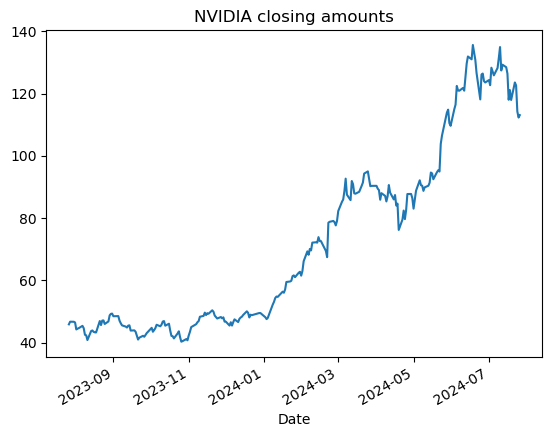

In [15]:
nvda['Close'].plot().set_title('NVIDIA closing amounts')
plt.show()

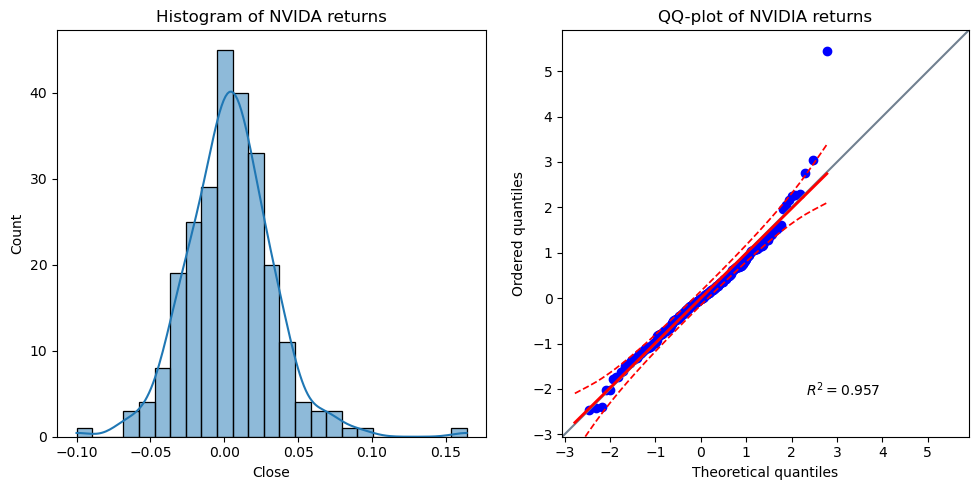

Pvalue of Shapiro-Wilk test: 6.402429515856917e-06
Reject H0 of normal distribution


In [4]:
import seaborn as sns
import pingouin as pg
from scipy.stats import shapiro

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

returns = nvda['Close'].pct_change().dropna()
sns.histplot(returns, kde = True, ax = ax[0]).set(title= 'Histogram of NVIDA returns')
pg.qqplot(returns, dist = 'norm', ax = ax[1]).set_title('QQ-plot of NVIDIA returns')
plt.tight_layout()
plt.show()

_, pval = shapiro(returns)
print(f'Pvalue of Shapiro-Wilk test: {pval}')
if pval <= 0.05: 
    print('Reject H0 of normal distribution')
else: 
    print('Normally distributed')

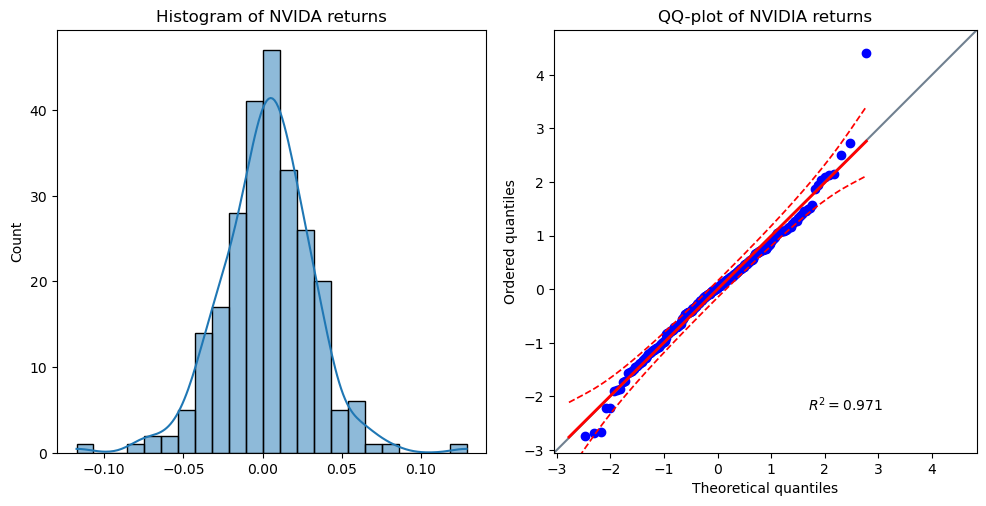

Pvalue of Shapiro-Wilk test: 0.0004847607673846856
Reject H0 of normal distribution


In [5]:
from scipy.stats import yeojohnson  
returns_yj = yeojohnson(returns)[0]

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

sns.histplot(returns_yj, kde = True, ax = ax[0]).set(title= 'Histogram of NVIDA returns')
pg.qqplot(returns_yj, dist = 'norm', ax = ax[1]).set_title('QQ-plot of NVIDIA returns')
plt.tight_layout()
plt.show()

_, pval = shapiro(returns_yj)
print(f'Pvalue of Shapiro-Wilk test: {pval}')
if pval <= 0.05: 
    print('Reject H0 of normal distribution')
else: 
    print('Normally distributed')

In [6]:
summary_stats_returns = {
    'mean' : returns.mean(), 
    'std' : returns.std(), 
    'kurtosis' : returns.kurtosis(), 
    'skewness': returns.skew()
}

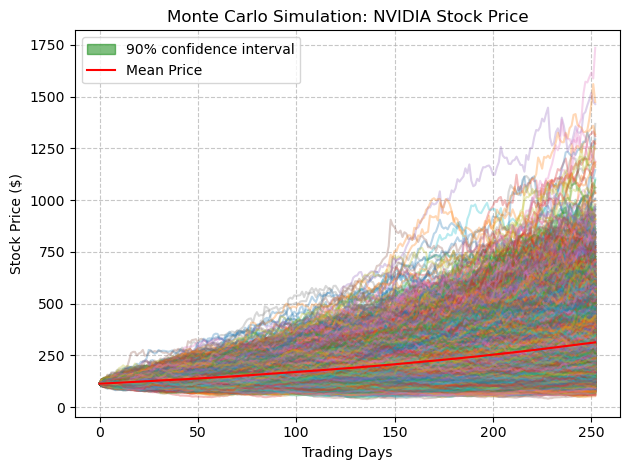

In [83]:
def bootstrap_returns(returns, n_days, n_simulations): 
    return np.random.choice(returns, size = (n_days, n_simulations), replace= True)

def simulate(initial_price, returns, n_days, n_simulations): 
    simulated_returns = bootstrap_returns(returns, n_days, n_simulations)
    
    price_paths = np.zeros((n_days + 1, n_simulations))
    price_paths[0] = initial_price
    for i in range(1, n_days + 1): 
        price_paths[i] = price_paths[i -1] * (1 + simulated_returns[i -1])
    return price_paths 

np.random.seed(1)    
days = 252
simulations = 10000
init_price = nvda['Close'].iloc[-1]

simulated_prices = simulate(init_price, returns, days, simulations)

mean_price = np.zeros(days + 1)
for i in range(len(mean_price)): 
    mean = np.mean(simulated_prices[i])
    mean_price[i] = mean

lower_bound = np.percentile(simulated_prices, 5, axis =1)
upper_bound = np.percentile(simulated_prices, 95, axis = 1)

plt.fill_between(range(days + 1), lower_bound, upper_bound, alpha = 0.5, color = 'green', label = '90% confidence interval')
plt.plot(simulated_prices[:, :10000], alpha = 0.3)
plt.plot(mean_price, color = 'r', alpha = 1, label = 'Mean Price')

plt.title('Monte Carlo Simulation: NVIDIA Stock Price')
plt.xlabel('Trading Days')
plt.ylabel('Stock Price ($)')
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.legend()
plt.tight_layout()
plt.show()